# Predicting Future Sales

This notebook contains the process of the data for my submission
to the Kaggle competition ["Predicting Future Sales"](https://www.kaggle.com/c/competitive-data-science-predict-future-sales).

A setup guide for the runtime environment can be found in the projects
[README](./README.adoc) file.

## Prerequisites

### Control notebook flow

In [1]:
run_eda = False
run_fe = False
run_model = True

### Imports

In [2]:
# Basic packages
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced features
from itertools import product  # make a cross product
from datetime import datetime
from calendar import monthrange  # get the amount of days in a given YYYY-MM

# Machine learning tools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance

# My packages
import src.plotting.Defaults
from src.datacleaning.ConvertingDateValues import date_to_month, date_to_iso8601, iso8601_format
from src.util.FunctionExecTime import time_runtime
from src.util.ParseDataframe import get_item_cnt_metric
from src.util.ListActions import cl

### Set package options

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

%matplotlib inline
# set the default marker style for all plots
src.plotting.Defaults.set_defaults()

### Import data

In [4]:
default_converters = {
    'date_block_num': eval,
    'shop_id': eval,
    'item_id': eval,
    'item_price': eval,
    'item_cnt_day': eval,
}

primary_columns = ['date_block_num', 'shop_id', 'item_id']

In [5]:
if run_eda or run_fe:
    # Metadata packages
    items = pd.read_csv('data/info/items.csv')
    shops = pd.read_csv('data/info/shops.csv')
    cats = pd.read_csv('data/info/item_categories.csv')

    # Train and test data
    train = pd.read_csv('data/technical/sales_train.csv',
                        parse_dates=['date'],
                        dayfirst=True,
                        converters=default_converters,
                        )
    test  = pd.read_csv('data/technical/test.csv',
                        converters=default_converters,
                        ).set_index('ID')

    # adapt data size
    train['date_block_num'] = train['date_block_num'].astype(np.int8)
    train['shop_id'] = train['shop_id'].astype(np.int8)
    train['item_id'] = train['item_id'].astype(np.int16)
    train['item_price'] = train['item_price'].astype(np.float32)

### Data formatting

In [6]:
if run_eda or run_fe:
    # contains the raw train with months only
    train_in_months = train.copy()
    train_in_months = time_runtime(date_to_month, train_in_months)

Map the date to its index for later use

In [7]:
def generate_date_mapper():
    """
    Map the date in YYYY-MM format to the given `date_block_num` table.
    """
    date_block_num_set = set(train_in_months['date_block_num'])
    date_set = set(train_in_months['date'])

    date_block_num_distinct = list(date_block_num_set)
    date_block_num_distinct.sort()
    date_distinct = list(date_set)
    date_distinct.sort()

    mapper = {}
    for i in date_block_num_distinct.__iter__():
        mapper.update({date_block_num_distinct[i]: date_distinct[i]})

    # append the month which is to be predicted
    mapper.update({34: '2015-11'})

    return mapper

def get_month_from_index(i):
    """
    Returns the month in 'YYYY-MM' format of a given `date_block_num` index.
    """
    return date_mapper.get(i)

def get_index_of_month(month):
    """
    Returns the index in the `date_block_num` table of a given month
    (in YYYY-MM format).
    """
    return list(date_mapper.keys())[list(date_mapper.values()).index(month)]

if run_eda or run_fe:
    date_mapper = generate_date_mapper()

<br><br><br><br><br><br><br><br><br><br>

## Exploratory Data Analysis

### Clean features

First, verify that there are no incomplete entries in the dataset:

In [8]:
if run_eda:
    train.isna().sum()

### View monthly sales

In [9]:
def view_all_sales():
    # create a new data frame with the relevant columns.
    df = pd.DataFrame(train_in_months, columns=['date', 'item_cnt_day'])
    df.set_index('date', inplace=True)

    # sum the values to get a monthly overview
    df = df.groupby(['date']).sum()

    # rename the column to match new output
    df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

    return df

if run_eda:
    all_sales = time_runtime(view_all_sales)

In [10]:
if run_eda:
    all_sales.plot()

We can observe a strong seasonality with spiking end of year sales.

This is particularly noteworthy as the month to predict in question is
going to be the month of november.

Additionally, the trend seems to be going downwards over time.


### View monthly revenue

In [11]:
def compute_revenue(df):
    item_cnt_metric = get_item_cnt_metric(df)
    df['revenue'] = df.apply(lambda x: x[item_cnt_metric] * x['item_price'], axis=1)
    return df

def check_revenue():
    # pick the relevant columns
    df = pd.DataFrame(train_in_months, columns=['date', 'item_cnt_day', 'item_price'])
    # calculate the revenue
    df = compute_revenue(df)
    # drop no longer needed columns
    df.drop(['item_cnt_day', 'item_price'], axis=1, inplace=True)

    # set the index
    df.set_index('date', inplace=True)
    # and regroup the monthly revenue
    return df.groupby(['date']).sum()

if run_eda:
    revenue = time_runtime(check_revenue)

In [12]:
if run_eda:
    revenue.plot()

Fortunately, the revenue is closely correlated to the total sales as expected.

### Inspect `item_cnt_day`

In [13]:
if run_eda:
    plt.figure(figsize=(10,2))
    sns.boxplot(x=train_in_months.item_cnt_day)

Two outliers can be observed. This will have to be examined further down the line.

### Inspect `item_price`

In [14]:
if run_eda:
    plt.figure(figsize=(10,2))
    sns.boxplot(x=train_in_months.item_price)

One outlier can be observed. This will have to be examined further down the line.


### Inspect `item_id`

In [15]:
def inspect_total_sales_per_item_cat():
    df = pd.DataFrame(train_in_months, columns=['item_cnt_day', 'item_id'])
    df = df.set_index('item_id', drop=True).join(items.set_index('item_id'))
    df.drop(['item_name'], axis=1, inplace=True)
    df.set_index(['item_category_id'], inplace=True)
    df = df.groupby(['item_category_id']).sum()
    df.rename(columns = {'item_cnt_day':'item_cnt_total'}, inplace = True)

    return df

if run_eda:
    sales_per_item_cat = time_runtime(inspect_total_sales_per_item_cat)

In [16]:
if run_eda:
    plt.figure(figsize=(12,5))
    plt.bar(sales_per_item_cat.index, sales_per_item_cat['item_cnt_total'])
    plt.xlabel("Item category ID")
    plt.ylabel("Total item category sales")

#### Inspect outliers

Obvious top-performers are found. Let's find out what the category corresponds
to as well as verify that there are no categories without any sale records.

In [17]:
if run_eda:
    top_performing_item_categories = sales_per_item_cat[sales_per_item_cat['item_cnt_total'] > 200_000]
    top_performing_item_categories = top_performing_item_categories.join(cats, on='item_category_id', how='inner')
    top_performing_item_categories.head(top_performing_item_categories.size)

Let's have a look at the translation ([using Google Translate](https://translate.google.com/?sl=ru&tl=en&op=translate))

| Russian                               | Translation                           |
| ------------------------------------- | ------------------------------------- |
| Игры - PS3                            | Games - PS3                           |
| Игры PC - Стандартные издания	        | PC Games - Standard Editions          |
| Кино - Blu-Ray	                    | Movie - Blu-Ray                       |
| Кино - DVD	                        | Movies - DVD                          |
| Музыка - CD локального производства   | Music - locally produced CD           |

In [18]:
if run_eda:
    low_performing_item_categories = sales_per_item_cat[sales_per_item_cat['item_cnt_total'] < 10]
    low_performing_item_categories = low_performing_item_categories.join(cats, on='item_category_id', how='inner')
    low_performing_item_categories.head(low_performing_item_categories.size)

Let's have a look at the translation ([using Google Translate](https://translate.google.com/?sl=ru&tl=en&op=translate))


| Russian                               | Translation                           |
| ------------------------------------- | ------------------------------------- |
| PC - Гарнитуры/Наушники	            | PC - Headsets / Headphones            |
| Аксессуары - PS2	                    | Accessories - PS2                     |
| Игровые консоли - PS2	                | Game consoles - PS2                   |
| Игры MAC - Цифра	                    | MAC Games - Number                    |
| Книги - Компьютерная литература	    | Books - Computer Literature           |
| Книги - Открытки	                    | Books - Postcards                     |
| Книги - Познавательная литература     | Books - Educational literature        |
| Книги - Путеводители                  | Books - Guides                        |
| Книги - Художественная литература     | Books - Fiction                       |

Books seem to be in very low demand. Let's find out if there are any other categories containing books.

In [19]:
if run_eda:
    other_book_cats = cats[cats['item_category_name'].str.contains("Книги")]
    other_book_cats.head(other_book_cats.size)

In [20]:
if run_eda:
    book_sales = sales_per_item_cat[sales_per_item_cat.index >= 42]
    book_sales = book_sales[book_sales.index <= 54]
    book_sales.head(book_sales.size)

Inspect the average amount of books sold, which is expected to be well
below average.

The most selling book subcategories within the book section are namely
category 43 with "Audiobooks" (Книги - Аудиокниги) and category 49
with "methodical materials" from the in-store brand from [1C](https://1c.ru/eng/title.htm).
(Книги - Методические материалы 1С)

In [21]:
# average amount of sold books per category
if run_eda:
    int(book_sales['item_cnt_total'].sum() / book_sales.size)

#### Inspect overall average of sales of each item category

In [22]:
# overall average of sold items per item category
if run_eda:
    int(sales_per_item_cat['item_cnt_total'].sum() / sales_per_item_cat.size)

#### Conclusion

We can see that for this "software store", media seems to be of particularly popular demand.

The categories containing various subcategories of books is well below the average demand in a store.

Potential features could be extracted from this information.

### Inspect `shop_id`

In [23]:
def inspect_total_sales_per_shop():
    df = pd.DataFrame(train_in_months, columns=['item_cnt_day', 'shop_id'])
    df.set_index(['shop_id'], inplace=True)
    df.rename(columns = {'item_cnt_day':'item_cnt_total'}, inplace = True)

    return df.groupby(['shop_id']).sum()

if run_eda:
    sales_per_shop = time_runtime(inspect_total_sales_per_shop)

In [24]:
if run_eda:
    plt.figure(figsize=(12,5))
    plt.bar(sales_per_shop.index, sales_per_shop['item_cnt_total'])
    plt.xlabel("Shop ID")
    plt.ylabel("Total shop sales")

#### Inspect outliers

Shop Nr. 36 appears to be non-existent. Let's verify that.

In [25]:
if run_eda:
    int(sales_per_shop.iloc[36]['item_cnt_total'])

#### Inspect overall average of sales per shop

In [26]:
if run_eda:
    int(sales_per_shop['item_cnt_total'].sum() / sales_per_shop.size)

#### Conclusion

We verified that each and every shop has a positive sales record.

The average value of 60k sales per shop in total can be confirmed in the bar diagram showing the distribution:
there are about as many shop's with under-average performance as there are shops with an exceptionally high record.

The location of the shops might be of additional interest.

Shop Nr. 55 is the Online Store of the company.

Shop Nr. 20 to 32 are all located in the capital city of Moscow


### Inspect the time series

In [27]:
if run_eda:
    train_in_iso8601 = train.copy()
    train_in_iso8601 = time_runtime(date_to_iso8601, train_in_iso8601)

In [28]:
if run_eda:
    all_dates = set()

def put_all_days_in_set():
    for index, row in train_in_iso8601.iterrows():
        date = row['date']  # access the row
        date = datetime.strptime(date, '%Y-%m-%d')  # convert to datetime format
        date_as_int = date.toordinal()  # convert to ordinal format for date arithmetic
        all_dates.add((date_as_int, date))  # add to set

if run_eda:
    time_runtime(put_all_days_in_set)

In [29]:
# transform the set to a list and sort it
if run_eda:
    all_dates = list(all_dates)
    all_dates.sort()

In [30]:
if run_eda:
    counter_entries_in_all_dates = len(all_dates)
    anomalies_in_date_series = set()

def check_for_interruptions():
    for i in range(counter_entries_in_all_dates):


        if i != (counter_entries_in_all_dates - 1):
            ordinal_this_date = all_dates[i][0]
            ordinal_successor_date = all_dates[i+1][0]

            if ordinal_this_date + 1 != ordinal_successor_date:
                print(f"{i}, {all_dates[i]}")
                anomalies_in_date_series.add(i)

if run_eda:
    time_runtime(check_for_interruptions)

In [31]:
if run_eda:
    all_dates[-1]

No breaks in between dates of sale made.

The last record is indeed on the last day of October.

### Inspect the correlation between features

In [32]:
def draw_correlation_matrix():
    corr = train.corr()

    # Generate a mask to hide duplicate values
    mask = np.triu(np.ones_like(corr, dtype=bool))

    ax = sns.heatmap(
        corr,
        mask=mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    # format the axis output
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );  # the ';' suppresses the output


if run_eda:
    draw_correlation_matrix()

We observe no strong correlation between the features at this point.
The only slight hint lies between the correlation between the `item_price` and the date of the sale in `date_block_num`.

### Results of the in-depth EDA.

Final observations from the [in-depth EDA](./In_Depth_EDA.ipynb).

The following datapoints from an item categories and shops perspective are indicating an unpredictable outcome that needs to be accounted for in the models.

*__Item categories:__*

The following categories have a mere one to two entries:

1, 10, 50, 51, 52

The following categories suggest very unpredictable results:

0, 18, 27, 36, 48, 53, 80

The following categories show a clear downward trend:

13, 21, 30, 40, 43, 45, 59, 62, 66, 77, 81, 82


*__Shops:__*

The following shops have a mere one to two entries:

0, 1, 11, 20, 36

The following shops suggest very unpredictable results:

8, 9, 23, 32, 33

The decline in sales per shop is not as striking as the one on a category basis.
This indicates that there are items going out of fashion while the shops are able to secure their relevancy in the market with an adapting supply.

### Inspect the submission set

The template for which features are to be predicted is included with the
challenge. As the dataset is highly volatile with selected shops having no sales
in given categories on a given month.
Let's analyse which items are relevant and included in previous data. We suspect
that there could be new items in the submission which have no record in
previous data at all.

#### Find newly appearing items

In [33]:
if run_eda:
    test_item_id_set = set(test.item_id)
    train_item_id_set = set(train.item_id)
    item_id_sets_intersection = test_item_id_set - test_item_id_set.intersection(train_item_id_set)
    len(item_id_sets_intersection)

#### Inspect the total of distinct test items

In [34]:
if run_eda:
    count_distinct_items = len(test_item_id_set)
    count_distinct_items

#### Inspect the total size of the test set

In [35]:
if run_eda:
    test_length = len(test)
    test_length

#### Find relation between items and shops

In [36]:
if run_eda:
    test_length / count_distinct_items

#### Approximate the existing coverage of entries

With having 5100 items from 42 shops inspected, while having a record of 33
months of data present. We can estimate the coverage of existing entries for
a given datapoint.

In [37]:
if run_eda:
    train_length = len(train)
    coverage = train_length / (test_length * 33)
    coverage

As we can see, there are a total of 5100 distinct items in the test set
which is to be predicted. The total size of the test data is 214.200, the
exact size of the submission sample.

The relationship between the total length and the distinct items conducts
that exactly 42 distinct shops are going to be predicted.

363 items are new in the test set which have
no record in any of the train data.

The newly added data will have to be accounted for and added to the train
set by adding datapoints which indicate the model that this item has not
been sold before.

Additionally, we observe that the coverage of dedicated entry point for a
given item is at best 42%. The high volatility and constantly changing
product range indicates that it is likely even less. It will be a good idea
to fill the train set with explicit zero sale entries for the items.


<br><br><br><br><br><br><br><br><br><br>

## Feature engineering

Begin by allocating a final dataframe where all the new features are going to
be stored.

In [38]:
if run_fe:
    feature_engineered = train_in_months.copy()

Before proceeding, store two hashmaps which contain the last months of sale
from a given item or item + shop combination.
This is done now to parse the data (~3 million combinations) before
inflating it with zero-sales later on (~10 million combination)

In [39]:
if run_fe:
    all_items_last_sale = {}
    all_items_first_sale = {}
    all_items_last_sale_per_shop = {}
    all_items_first_sale_per_shop = {}

def parse_table_and_store_most_recent_sale(df):

    global all_items_last_sale, all_items_last_sale_per_shop
    global all_items_first_sale, all_items_first_sale_per_shop

    for i, row in df.iterrows():
        # assign the keys for both dicts
        key_item = row.item_id
        key_pair = (row.item_id, row.shop_id)

        # if the key was not present yet, add it
        if key_pair not in all_items_last_sale_per_shop:
            all_items_first_sale_per_shop[key_pair] = row.date_block_num
            all_items_last_sale_per_shop[key_pair] = row.date_block_num
        # else, verify that the sale is indeed more recent
        else:
            if row.date_block_num >= all_items_last_sale_per_shop[key_pair]:
                # and add it if successful
                all_items_last_sale_per_shop[key_pair] = row.date_block_num
            else:
                all_items_first_sale_per_shop[key_pair] = row.date_block_num


        # do it again for the isolated item
        if key_item not in all_items_last_sale:
            all_items_first_sale[key_item] = row.date_block_num
            all_items_last_sale[key_item] = row.date_block_num
        else:
            if row.date_block_num >= all_items_last_sale[key_item]:
                all_items_last_sale[key_item] = row.date_block_num
            else:
                all_items_first_sale[key_item] = row.date_block_num

if run_fe:
    time_runtime(parse_table_and_store_most_recent_sale, feature_engineered)

### Append the test data

In [40]:
def append_test_data(df):
    df_test = test.copy()
    df_test['date'] = '2015-11'
    df_test['date_block_num'] = 34
    return df.append(df_test)

if run_fe:
    feature_engineered = append_test_data(feature_engineered)

### Batch feature engineering

Create a function which makes sure to apply the same operations on the train
and testing dataset.

In [41]:
def apply_feature_engineering(df):
    """
    Calls all functions to apply the feature engineering equally on the
    train and test dataset.
    """
    df = time_runtime(regroup_monthly_sales, df)
    df = time_runtime(apply_cat_info, df)
    df = time_runtime(apply_shop_duplicates, df)
    df = time_runtime(apply_shop_location, df)
    df = time_runtime(encode_categorical_data, df)

    df = time_runtime(add_item_cat_avg_price, df)
    df = time_runtime(apply_item_cat_avg_price_to_new_items, df)
    df = time_runtime(apply_revenue_feature, df)
    df = time_runtime(fillna_revenue_new_items, df)

    df = time_runtime(add_month_feature, df)
    df = time_runtime(add_days_in_month, df)
    df = time_runtime(add_item_last_sale_in_shop, df)
    df = time_runtime(add_item_last_sale, df)
    df = time_runtime(add_item_first_sale_in_shop, df)
    df = time_runtime(add_item_first_sale, df)


    df = time_runtime(create_zero_sales, df)
    df = time_runtime(fill_missing_data, df)

    df = time_runtime(apply_label_lag_feature, df)
    df = time_runtime(add_detailed_lag_features, df)
    df = time_runtime(add_average_price, df)
    df = time_runtime(add_average_price_during_month, df)
    df = time_runtime(add_lag_to_avg_price_during_month, df)
    df = time_runtime(add_price_trend, df)
    df = time_runtime(add_shop_revenue_per_month, df)
    df = time_runtime(add_shop_avg_revenue, df)
    df = time_runtime(add_shop_avg_revenue_trend, df)
    df = time_runtime(add_shop_avg_revenue_trend_lag, df)

    df = time_runtime(fillna_lag_features, df)
    return df

Create a static list to store the categorical columns to encode these later on.

In [42]:
if run_fe:
    encode_categorical_features = set()
    track_all_lag_features = set()

### Convert the daily sales record to a monthly rhythm

In [43]:
def regroup_monthly_sales(df):

    cols = ['date_block_num','shop_id','item_id']

    df_item_price = df.groupby(cols).agg({'item_price': ['mean']})
    df = df.groupby(cols).agg({'item_cnt_day': ['sum']})

    df = pd.merge(df, df_item_price, how="inner", on=cols)

    df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
    # clip it according to the description of the competition
    df['item_cnt_month'] = df['item_cnt_month'].clip(0, 20)
    df.reset_index(inplace=True)

    df = add_dateblocknum_to_date(df)

    # remove the multi-index create by the `agg` function
    df.columns = df.columns.droplevel(1)
    df['item_cnt_month'] = df['item_cnt_month'].astype(np.float16)

    return df


def add_dateblocknum_to_date(df):
    df['date'] = df['date_block_num'].apply(lambda x: get_month_from_index(x))
    return df

### Add information about the categories

In [44]:
def add_item_category_id(df):
    df = pd.merge(df, items, on='item_id')
    df.drop(['item_name'], axis=1, inplace=True)
    df['item_category_id'] = df['item_category_id'].astype(np.int8)
    return df

In [45]:
def get_category_info(df):
    global encode_categorical_features
    """
    Return the dataframe containing all the additional information about the
    item categories. Read the CSV, drop the irrelevant tables and join on the
    item_category_id.
    """
    cat_info = pd.read_csv("data/feature_engineering/item_categories_classified.csv")
    cat_info.drop(['item_category_name', 'english_name'], axis=1, inplace=True)

    encode_categorical_features.add('category_type')
    encode_categorical_features.add('category_device')
    encode_categorical_features.add('category_device_for_platform')
    encode_categorical_features.add('category_device_for_platform_manufacturer')
    encode_categorical_features.add('category_medium_type')

    df = pd.merge(df, cat_info, on='item_category_id')

    df['category_is_fancy'] = df['category_is_fancy'].astype(bool)
    return df

In [46]:
def apply_cat_info(df):
    df = add_item_category_id(df)
    df = get_category_info(df)
    return df

### Encode categorical data

In [47]:
def encode_categorical_data(df):
    global encode_categorical_features

    for cat_feat in encode_categorical_features:
        df[f'{cat_feat}'] = LabelEncoder().fit_transform(df[cat_feat])
        df[f'{cat_feat}'] = df[f'{cat_feat}'].astype(np.int8)
    return df

### Fill the train data

#### Add the missing data

Populate the train data with non-existing sales to indicate that the item
is accounted for but has not been sold in a given month.

In [48]:
def merge_remaining_data_back(df, df_cp, cols):
    """
    Merge the cross-product dataframe with zero-sales and drop the duplicated
    values at the end.
    """
    df = pd.merge(df, df_cp, on=cols, how="outer")
    return df.drop_duplicates(cols)


def create_zero_sales(df):
    """
    Create a cross-product between the date_block_num, unique shop_id's and
    unique item_id's. This will allow us to indicate sales that have never
    happened to allow for a more even distribution of the sales.
    """
    df_cross_product = []
    relevant_cols = ['date_block_num', 'shop_id', 'item_id']
    for i in range(34):
        sales = df[df.date_block_num == i]
        df_cross_product.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())),
                                         dtype='int16'))

    df_cross_product = pd.DataFrame(np.vstack(df_cross_product), columns=relevant_cols)
    df_cross_product['date_block_num'] = df_cross_product['date_block_num'].astype(np.int8)
    df_cross_product['shop_id'] = df_cross_product['shop_id'].astype(np.int8)
    df_cross_product['item_id'] = df_cross_product['item_id'].astype(np.int16)
    df_cross_product.sort_values(relevant_cols,inplace=True)

    df_cross_product = merge_remaining_data_back(df, df_cross_product, relevant_cols)

    return df_cross_product

#### Fill the missing data

In [49]:
def fill_with_itemprice_mean(df):

    df_item_price_avg = df.groupby('item_id').agg({'item_price': ['mean']})
    df_item_price_avg.columns = df_item_price_avg.columns.droplevel(1)

    # transform to hashmap to make quicker searches
    price_avg_dict = df_item_price_avg.to_dict()
    price_avg_dict = price_avg_dict.get('item_price')

    df['item_price'] = df.apply(
        lambda row: price_avg_dict.get(row['item_id'])
        if np.isnan(row['item_price']) else row['item_price'],
        axis=1
    )

    return df

def fill_zero_sales(df):
    df['item_cnt_month'] = df['item_cnt_month'].fillna(0)
    return df

def fill_missing_data(df):
    df = add_dateblocknum_to_date(df)
    df = fill_zero_sales(df)
    df = fill_with_itemprice_mean(df)
    return df

### Shops

#### Duplicated shops

When inspecting their names, A few shops appear to be duplicates of each other.
Namely:

| Shop name                         | Shop ID | Shop name                   | Shop ID |
| -------------------------         | ------- | --------------------------- | ------- |
| !Якутск Орджоникидзе, 56 фран     | 0       | Якутск Орджоникидзе, 56     | 57      |
| !Якутск ТЦ "Центральный" фран     | 1       | Якутск ТЦ "Центральный"     | 58      |
| Жуковский ул. Чкалова 39м?        | 10      | Жуковский ул. Чкалова 39м²  | 11      |

"фран" means "fran". Most likely meaning "franchise".

Fortunately, this eliminates 3 of the 5 shops with few data entries from the shop list. (0, 1 and 11)

In [50]:
def apply_shop_duplicates(df):
    """
    Fix the duplicated shops from the data. Pass a dataframe (train/test)
    to apply the fix to all the entries.
    """
    df.loc[df.shop_id == 0, 'shop_id'] = 57
    df.loc[df.shop_id == 1, 'shop_id'] = 58
    df.loc[df.shop_id == 11, 'shop_id'] = 10
    return df

#### Shop location

Preparation: craft a new feature from examining the locations in Russia
from all stores.
First, put all the cities into a dedicated dataframe to closely inspect all
distinct locations.

In [51]:
if run_fe:
    shops_cities_distribution = pd.DataFrame()
    shops_cities_distribution['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
    # the earlier found cities that are prepended with an exclamation mark are removed:
    shops_cities_distribution.loc[shops_cities_distribution.city == '!Якутск', 'city'] = 'Якутск'

    # drop the duplicated cities and get a table containing all 31 cities
    shops_cities_distribution.drop_duplicates(inplace=True)
    shops_cities_distribution.reset_index(inplace=True, drop=True)

Prepare the data containing more detailed information about the physical
location of the shops.
As the location match several shops, the dataset contains a list of all the
shops where they apply to and therefore need to be assigned new rows to be
able to merge it later on.

In [52]:
def get_shop_info():
    """
    Return the dataframe containing all the additional information about the
    single shops. Read the CSV, drop the irrelevant tables and parse the shop_id
    that are stored as String into a dedicated list.
    """

    shop_info = pd.read_csv("data/feature_engineering/cities.csv",
                            converters={
                                'zip_code': eval,
                                'population': eval,
                                'population_growth': eval,
                                'region_gdp_in_usd': eval,
                            }
                            )
    # drop additional information
    shop_info.drop(['wiki', 'additional_links', 'gdp_source', 'city', 'city_in_english'], axis=1, inplace=True)
    # store the column names for later use
    shop_info_indices = list(shop_info.columns)
    # transform the shop_id CSV string to list
    shop_info['shop_ids'] = shop_info['shop_ids'].transform(lambda x: x.split(";"))

    # assign every entry in shop_ids into their own row
    for _, row in shop_info.iterrows():  # for every row
        new_row = {}  # create a new dict to store new values
        for shop_id in row['shop_ids']:  # for every shop_id in shop_ids
            new_row['shop_id'] = int(shop_id)  # assign the found shop_id
            for key in shop_info_indices:  # add the old key/value pairs
                if key != "shop_ids":  # ignore the shop_ids
                    new_row[key] = row[key]  # assign the key/value
            shop_info = shop_info.append(new_row, ignore_index=True)  # append the new dict
        shop_info.drop(index=0, inplace=True)  # drop the old entry which is always the first entry

    shop_info.drop(["shop_ids"], axis=1, inplace=True)  # drop the no longer needed column

    encode_categorical_features.add('region')
    return shop_info

Merge the location data

In [53]:
def apply_shop_location(df):
    global encode_categorical_features
    shop_info = get_shop_info()
    df =pd.merge(df, shop_info, on="shop_id", how="inner")
    df['zip_code'] = df['zip_code'].astype(np.int16)
    df['population'] = df['population'].astype(np.int32)
    df['population_growth'] = df['population_growth'].astype(np.float16)
    df['region_gdp_in_usd'] = df['region_gdp_in_usd'].astype(np.int16)
    return df

### Add the revenue feature

In [54]:
def apply_revenue_feature(df):
    return compute_revenue(df)

### Add lag features

In [55]:
def compute_lag_feature(df, lags, feature):
    global track_all_lag_features
    tmp = df[cl(primary_columns, feature)]
    for i in lags:
        shifted = tmp.copy()
        new_col_name = f"{feature}_lag_{str(i)}"
        shifted.columns = cl(primary_columns, new_col_name)
        # shift to the right according to the index
        shifted['date_block_num'] += i
        # merge on the primary columns
        df = pd.merge(df, shifted, on=primary_columns, how='left')
        track_all_lag_features.add(new_col_name)
    return df

#### Start with the label

We are going to lag the target label. We are going to check how many times the
item has been sold `i` months prior.

In [56]:
def apply_label_lag_feature(df):
    lags = [1, 2, 3, 6, 12]
    feature = 'item_cnt_month'
    df = compute_lag_feature(df, lags, feature)

    for lag in lags:
        new_col_name = f"{feature}_lag_{str(lag)}"
        df[new_col_name] = df[new_col_name].astype(np.float16)

    return df

#### Add more detailed lag features

In [57]:
def pass_lag_features(df, group, target):
    # calculate the mean of the targeted group
    group_with_mean = df.groupby(group).agg({'item_cnt_month': ['mean']})
    # create the new target column for the lag feature to be stored to
    group_with_mean.columns = [target]
    # reset the index
    group_with_mean.reset_index(inplace=True)

    # merge the new data
    df = pd.merge(df, group_with_mean, on=group, how='left')
    # define the column type
    df[target] = df[target].astype(np.float16)
    # calculate the lag feature with the previously computed mean value
    df = compute_lag_feature(df, [1, 2, 3, 6, 12], target)
    # drop the mean column as it has been added as lag feature
    df.drop([target], axis=1, inplace=True)
    return df

def add_detailed_lag_features(df):
    df = pass_lag_features(df, ['date_block_num'],
                                'date_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'item_id'],
                                'date_item_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'shop_id'],
                                'date_shop_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'zip_code'],
                                'date_city_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'item_id', 'zip_code'],
                                'date_item_city_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'item_category_id'],
                           'date_cat_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'shop_id', 'item_category_id'],
                           'date_shop_cat_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'shop_id', 'category_type'],
                           'date_shop_cat-type_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'shop_id', 'category_device'],
                           'date_shop_cat-device_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'category_type'],
                           'date_cat-type_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'category_device'],
                           'date_cat-device_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'category_medium_type'],
                           'date_cat-medium-type_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'shop_id', 'category_medium_type'],
                           'date_shop_cat-medium-type_avg_item_cnt')

    return df

### Add trend feature for item prices

#### Compute average price

In [58]:
def add_average_price(df):
    target_col = 'item_avg_price'
    group_on = ['item_id']
    avg_price_grp = df.groupby(group_on).agg({'item_price': ['mean']})
    avg_price_grp.columns = [target_col]
    avg_price_grp.reset_index(inplace=True)
    avg_price_grp[target_col] = avg_price_grp[target_col].astype(np.float32)

    df = pd.merge(df, avg_price_grp, on=group_on, how='left')
    df[target_col] = df[target_col].astype(np.float16)
    return df

#### Compute average price on a given month

In [59]:
def add_average_price_during_month(df):
    target_col = 'item_avg_price_during_month'
    group_on = ['date_block_num', 'item_id']
    avg_price_grp = df.groupby(group_on).agg({'item_price': ['mean']})
    avg_price_grp.columns = [target_col]
    avg_price_grp.reset_index(inplace=True)
    avg_price_grp[target_col] = avg_price_grp[target_col].astype(np.float32)


    df = pd.merge(df, avg_price_grp, on=group_on, how='left')
    df[target_col] = df[target_col].astype(np.float16)
    return df

#### Compute price lag

In [60]:
if run_fe:
    price_trend_lag = [1, 2, 3, 4, 5, 6]

def add_lag_to_avg_price_during_month(df):
    return compute_lag_feature(df, price_trend_lag, 'item_avg_price_during_month')

#### Compute price lag evolution

In [61]:
def add_price_trend(df):
    avg_p = 'item_avg_price'
    for lag in price_trend_lag:
        target_col = f'delta_price_trend_with_lag_{lag}'
        avg_p_lag = f'item_avg_price_during_month_lag_{lag}'
        df[target_col] = (df[avg_p_lag] - df[avg_p]) / df[avg_p]
        track_all_lag_features.add(target_col)
    return df

### Add trend feature for shop revenue

In [62]:
def add_shop_revenue_per_month(df):
    target_col = 'shop_revenue_this_month'
    group_on = ['date_block_num', 'shop_id']
    avg_price_grp = df.groupby(group_on).agg({'revenue': ['sum']})
    avg_price_grp.columns = [target_col]
    avg_price_grp.reset_index(inplace=True)

    df = pd.merge(df, avg_price_grp, on=group_on, how='left')
    df[target_col] = df[target_col].astype(np.float32)

    return df

In [63]:
def add_shop_avg_revenue(df):
    target_col = 'shop_avg_revenue'
    group_on = ['shop_id']
    avg_price_grp = df.groupby(group_on).agg({'shop_revenue_this_month': ['mean']})
    avg_price_grp.columns = [target_col]
    avg_price_grp.reset_index(inplace=True)

    df = pd.merge(df, avg_price_grp, on=group_on, how='left')
    df[target_col] = df[target_col].astype(np.float32)

    return df

In [64]:
def add_shop_avg_revenue_trend(df):
    target_col = f'delta_shop_revenue_this_month'
    monthly_value = 'shop_revenue_this_month'
    avg_revenue = 'shop_avg_revenue'

    df[target_col] = (df[monthly_value] - df[avg_revenue]) / df[avg_revenue]
    df[target_col] = df[target_col].astype(np.float16)
    return df

In [65]:
def add_shop_avg_revenue_trend_lag(df):
    return compute_lag_feature(df, [1, 2, 3], 'delta_shop_revenue_this_month')

### Add feature with information about the most recent sales

In [66]:
def add_item_last_sale_in_shop(df):
    new_col = 'item_last_sold_in_given_shop'
    df[new_col] = -1
    df[new_col] = df[new_col].astype(np.int8)
    df[new_col] = df.apply(
        lambda x: all_items_last_sale_per_shop.get( (x['item_id'], x['shop_id']) , -1),
        axis=1
    )

    df[new_col] = df[new_col].astype(np.int8)

    return df

In [67]:
def add_item_last_sale(df):
    new_col = 'item_last_sold'
    df[new_col] = -1
    df[new_col] = df[new_col].astype(np.int8)
    df[new_col] = df.apply(
        lambda x: all_items_last_sale.get( (x['item_id']) , -1),
        axis=1
    )

    df[new_col] = df[new_col].astype(np.int8)

    return df

In [68]:
def add_item_first_sale_in_shop(df):
    new_col = 'item_first_sold_in_given_shop'
    df[new_col] = -1
    df[new_col] = df[new_col].astype(np.int8)
    df[new_col] = df.apply(
        lambda x: all_items_first_sale_per_shop.get( (x['item_id'], x['shop_id']) , -1),
        axis=1
    )

    df[new_col] = df[new_col].astype(np.int8)

    return df

In [69]:
def add_item_first_sale(df):
    new_col = 'item_first_sold'
    df[new_col] = -1
    df[new_col] = df[new_col].astype(np.int8)
    df[new_col] = df.apply(
        lambda x: all_items_first_sale.get( (x['item_id']) , -1),
        axis=1
    )

    df[new_col] = df[new_col].astype(np.int8)

    return df

### Add feature about month metadata

In [70]:
def add_month_feature(df):
    df['month'] = df.apply(lambda x: int(x['date'].split("-")[1]), axis=1)
    df['month'] = df['month'].astype(np.int8)
    return df

In [71]:
def add_days_in_month(df):
    days_in_month = {}
    for _, yyyy_mm in date_mapper.items():
        split = yyyy_mm.split("-")
        year = int(split[0])
        month = int(split[1])
        days_in_month.update({yyyy_mm: monthrange(year, month)[1]})

    df['days_in_month'] = df.apply(lambda x: days_in_month.get(x['date']), axis=1)
    df['days_in_month'] = df['days_in_month'].astype(np.int8)
    return df

### Fill NaN for the lag features

In [72]:
def fillna_lag_features(df):
    for col in track_all_lag_features:
        df[col].fillna(0, inplace=True)
    return df

### Compute item category average price

In [73]:
def add_item_cat_avg_price(df):
    target_col = 'item_cat_avg_price'
    group_on = ['item_category_id']
    avg_price_grp = df.groupby(group_on).agg({'item_price': ['mean']})
    avg_price_grp.columns = [target_col]
    avg_price_grp.reset_index(inplace=True)

    df = pd.merge(df, avg_price_grp, on=group_on, how='left')
    df[target_col] = df[target_col].astype(np.float32)

    return df

In [74]:
def apply_item_cat_avg_price_to_new_items(df):
    df['item_price'] = df.apply(
        lambda row: row['item_cat_avg_price']
        if np.isnan(row['item_price']) else row['item_price'],
        axis=1
    )
    return df

In [75]:
def fillna_revenue_new_items(df):
    df['revenue'].fillna(0, inplace=True)
    return df

In [76]:
def drop_month_col(df):
    return df.drop(['date'], axis=1)

In [77]:
def fix_col_data_types(df):
    df['date_block_num'] = df['date_block_num'].astype(np.int8)
    df['shop_id'] = df['shop_id'].astype(np.int8)
    df['item_id'] = df['item_id'].astype(np.int16)
    df['item_price'] = df['item_price'].astype(np.float32)
    return df

### Apply the feature engineering

In [78]:
# feature_engineered = apply_feature_engineering(feature_engineered)

In [79]:
if run_fe:
    feature_engineered = time_runtime(regroup_monthly_sales, feature_engineered)

    feature_engineered = time_runtime(create_zero_sales, feature_engineered)
    feature_engineered = time_runtime(fill_missing_data, feature_engineered)

    feature_engineered = time_runtime(apply_cat_info, feature_engineered)
    feature_engineered = time_runtime(apply_shop_duplicates, feature_engineered)
    feature_engineered = time_runtime(apply_shop_location, feature_engineered)
    feature_engineered = time_runtime(encode_categorical_data, feature_engineered)

    feature_engineered = time_runtime(add_item_cat_avg_price, feature_engineered)
    feature_engineered = time_runtime(apply_item_cat_avg_price_to_new_items, feature_engineered)
    feature_engineered = time_runtime(apply_revenue_feature, feature_engineered)
    feature_engineered = time_runtime(fillna_revenue_new_items, feature_engineered)

    feature_engineered = time_runtime(add_month_feature, feature_engineered)
    feature_engineered = time_runtime(add_days_in_month, feature_engineered)
    feature_engineered = time_runtime(add_item_last_sale_in_shop, feature_engineered)
    feature_engineered = time_runtime(add_item_last_sale, feature_engineered)
    feature_engineered = time_runtime(add_item_first_sale_in_shop, feature_engineered)
    feature_engineered = time_runtime(add_item_first_sale, feature_engineered)

    feature_engineered = time_runtime(apply_label_lag_feature, feature_engineered)
    feature_engineered = time_runtime(add_detailed_lag_features, feature_engineered)
    feature_engineered = time_runtime(add_average_price, feature_engineered)
    feature_engineered = time_runtime(add_average_price_during_month, feature_engineered)
    feature_engineered = time_runtime(add_lag_to_avg_price_during_month, feature_engineered)
    feature_engineered = time_runtime(add_price_trend, feature_engineered)
    feature_engineered = time_runtime(add_shop_revenue_per_month, feature_engineered)
    feature_engineered = time_runtime(add_shop_avg_revenue, feature_engineered)
    feature_engineered = time_runtime(add_shop_avg_revenue_trend, feature_engineered)
    feature_engineered = time_runtime(add_shop_avg_revenue_trend_lag, feature_engineered)

    feature_engineered = time_runtime(fillna_lag_features, feature_engineered)
    feature_engineered = time_runtime(drop_month_col, feature_engineered)
    feature_engineered = time_runtime(fix_col_data_types, feature_engineered)

### Serialize data to store it locally

In [80]:
if run_fe:
    feature_engineered.to_pickle('data.pkl')

## Model training

### Preparation

In [81]:
true_false_matrix = [True, False]

#### Import data

In [82]:
if run_model:
    data = pd.read_pickle('data.pkl')
    data = data[data.date_block_num > 11]

#### Assign train and test

In [83]:
if run_model:
    X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    Y_train = data[data.date_block_num < 33]['item_cnt_month']

    X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    Y_valid = data[data.date_block_num == 33]['item_cnt_month']

    X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

#### Run scaler

In [84]:
def scale():
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_valid_s = scaler.fit_transform(X_valid)
    X_test_s = scaler.fit_transform(X_test)

    return X_train_s, X_valid_s, X_test_s

if run_model:
    X_train_scaled, X_valid_scaled, X_test_scaled = time_runtime(scale)

Runtime of function "scale": 1min & 28s


### Template functions

In [85]:
def make_model(model, x_tr, y_tr, params):

    model.fit(x_tr, y_tr, **params)

    return model

#### Predict

In [86]:
def predict_model(model, x_val, x_te):
    y_pred = model.predict(x_val).clip(0, 20)
    y_test = model.predict(x_te).clip(0, 20)
    return y_pred, y_test

#### Export predictions

In [87]:
test  = pd.read_csv('data/technical/test.csv').set_index('ID')

def generate_submission(y_test, out):
    submission = pd.DataFrame({
        "ID": test.index,
        "item_cnt_month": y_test
    })
    submission.to_csv(f'{out}.csv', index=False)

#### Workflow

In [88]:
def do_prediction(model, out, param, x_tr, y_tr, x_val, x_te):
    model = make_model(model, x_tr, y_tr, param)
    y_pred, y_test = predict_model(model, x_val, x_te)
    generate_submission(y_test, out)
    return model

### Linear regression model

In [89]:
def make_lr_model():

    lr_params = {}

    model = do_prediction(LinearRegression(), "lr", lr_params,
                  X_train_scaled, Y_train,
                  X_valid_scaled, X_test_scaled
                  )
    return model

# if run_model:
#     lr_model = time_runtime(make_lr_model)

### XGBoost model

In [90]:
def make_xg_model():

    xg_params = {'eval_metric': "rmse",
                 'eval_set': [(X_train_scaled, Y_train), (X_valid_scaled, Y_valid)],
                 'verbose': True,
                 'early_stopping_rounds': 10
                 }

    model = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.3,
        seed=42
    )

    model = do_prediction(model, "xg", xg_params,
                  X_train_scaled, Y_train,
                  X_valid_scaled, X_test_scaled
                  )

    return model


if run_model:
    xg_model = time_runtime(make_xg_model)


[0]	validation_0-rmse:0.91338	validation_1-rmse:0.87326
[1]	validation_0-rmse:0.71351	validation_1-rmse:0.70542
[2]	validation_0-rmse:0.58887	validation_1-rmse:0.62962
[3]	validation_0-rmse:0.54460	validation_1-rmse:0.60887
[4]	validation_0-rmse:0.48772	validation_1-rmse:0.59400
[5]	validation_0-rmse:0.45393	validation_1-rmse:0.59613
[6]	validation_0-rmse:0.43241	validation_1-rmse:0.60466
[7]	validation_0-rmse:0.42005	validation_1-rmse:0.61308
[8]	validation_0-rmse:0.41298	validation_1-rmse:0.62206
[9]	validation_0-rmse:0.40713	validation_1-rmse:0.62644
[10]	validation_0-rmse:0.40413	validation_1-rmse:0.62689
[11]	validation_0-rmse:0.40115	validation_1-rmse:0.63100
[12]	validation_0-rmse:0.39863	validation_1-rmse:0.63423
[13]	validation_0-rmse:0.39729	validation_1-rmse:0.63452
[14]	validation_0-rmse:0.39632	validation_1-rmse:0.63613


/home/ced/Apps/miniconda3/envs/rp/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Runtime of function "make_xg_model": 2min & 12s


### Evaluate model

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

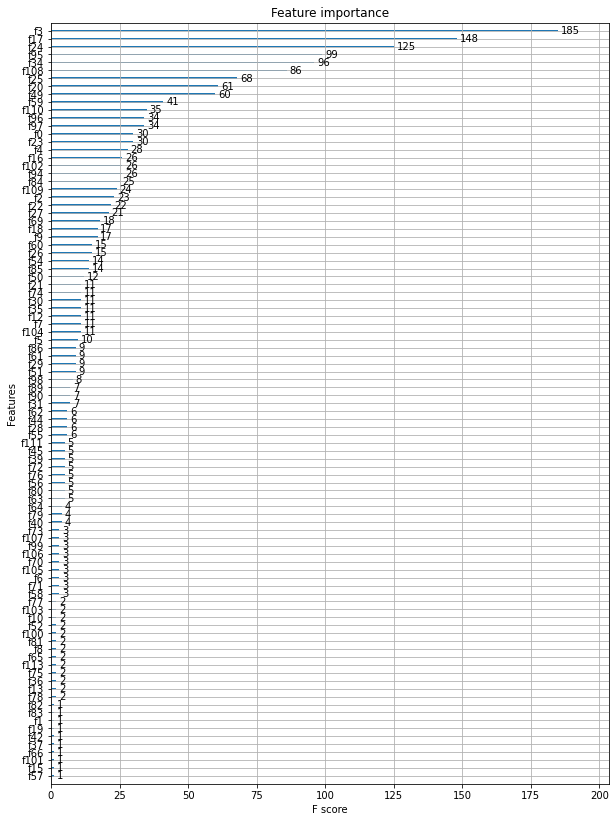

In [91]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xg_model, (10,14))